In [1]:
cd ..

/home/janek/mag/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from src.reasoner_mod import *
from src.generate import load_dataset, split_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

data_test = pd.DataFrame({
    'ontology_id': data_te[0],
    'X': data_te[1],
    'y': data_te[2]
})
data_tr_p2, data_vl_p2, data_te = split_dataset(data_test, 'ontology_id', 'y', seed=seed, test_size=0.2, val_size=0.1)

X_train = data_tr_p2['X'].tolist()
y_train = data_tr_p2['y'].tolist()
ontology_id_train = data_tr_p2['ontology_id'].tolist()

data_tr_p2 = [ontology_id_train, X_train, y_train] 

X_val = data_vl_p2['X'].tolist()
y_val = data_vl_p2['y'].tolist()
ontology_id_val = data_vl_p2['ontology_id'].tolist()

data_vl_p2 = [ontology_id_val, X_val, y_val] 

X_te = X_test = data_te['X'].tolist()
y_te = y_test = data_te['y'].tolist()
idx_te = ontology_id_test = data_te['ontology_id'].tolist()


emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32
#FIRST PHASE

In [4]:
reasoner_original = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
print(f'created reasoner with {paramcount(reasoner_original)} parameters')
reasoner_mod = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
print(f'created reasoner with {paramcount(reasoner_mod)} parameters')


reasoner_original.load_state_dict(T.load('local/out/exp/20240808T145442/reasonerO.pt'))
reasoner_mod.load_state_dict(T.load('local/out/exp/20240808T145442/reasonerM.pt'))

created reasoner with 3293 parameters
created reasoner with 3283 parameters


<All keys matched successfully>

In [5]:
## --- SECOND PHASE
trained_test_encoders = {}
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'original reasoner':
        train(data_tr_p2, data_vl_p2, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)
    else:
        train_mod(data_tr_p2, data_vl_p2, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)


original reasoner
train epoch 00/10 | batch 876/875 | loss 1.3760 | val loss 1.4245 | acc 0.5735 | f1 0.3946 | prec 0.2857 | recall 0.6376 | roc auc 0.6610 | pr auc 0.4860 | elapsed 7.91s
train epoch 01/10 | batch 876/875 | loss 1.1923 | val loss 1.0502 | acc 0.6390 | f1 0.4351 | prec 0.3302 | recall 0.6376 | roc auc 0.7111 | pr auc 0.5394 | elapsed 19.50s
train epoch 02/10 | batch 876/875 | loss 0.8413 | val loss 0.7683 | acc 0.7145 | f1 0.5022 | prec 0.4051 | recall 0.6606 | roc auc 0.7625 | pr auc 0.6060 | elapsed 18.17s
train epoch 03/10 | batch 876/875 | loss 0.5925 | val loss 0.5762 | acc 0.7812 | f1 0.5734 | prec 0.4987 | recall 0.6743 | roc auc 0.8087 | pr auc 0.6758 | elapsed 20.06s
train epoch 04/10 | batch 876/875 | loss 0.4285 | val loss 0.4533 | acc 0.8315 | f1 0.6400 | prec 0.5990 | recall 0.6869 | roc auc 0.8451 | pr auc 0.7381 | elapsed 23.15s
train epoch 05/10 | batch 876/875 | loss 0.3253 | val loss 0.3759 | acc 0.8682 | f1 0.7011 | prec 0.6936 | recall 0.7087 | roc a

In [6]:
with T.no_grad():
    _, _, Y_te_orig = eval_batch(reasoner_original, trained_test_encoders['original reasoner'], X_te, y_te, idx_te)
    _, _, Y_te_mod = eval_batch(reasoner_mod, trained_test_encoders['modified reasoner'], X_te, y_te, idx_te)

local/out/exp/20240808T160724


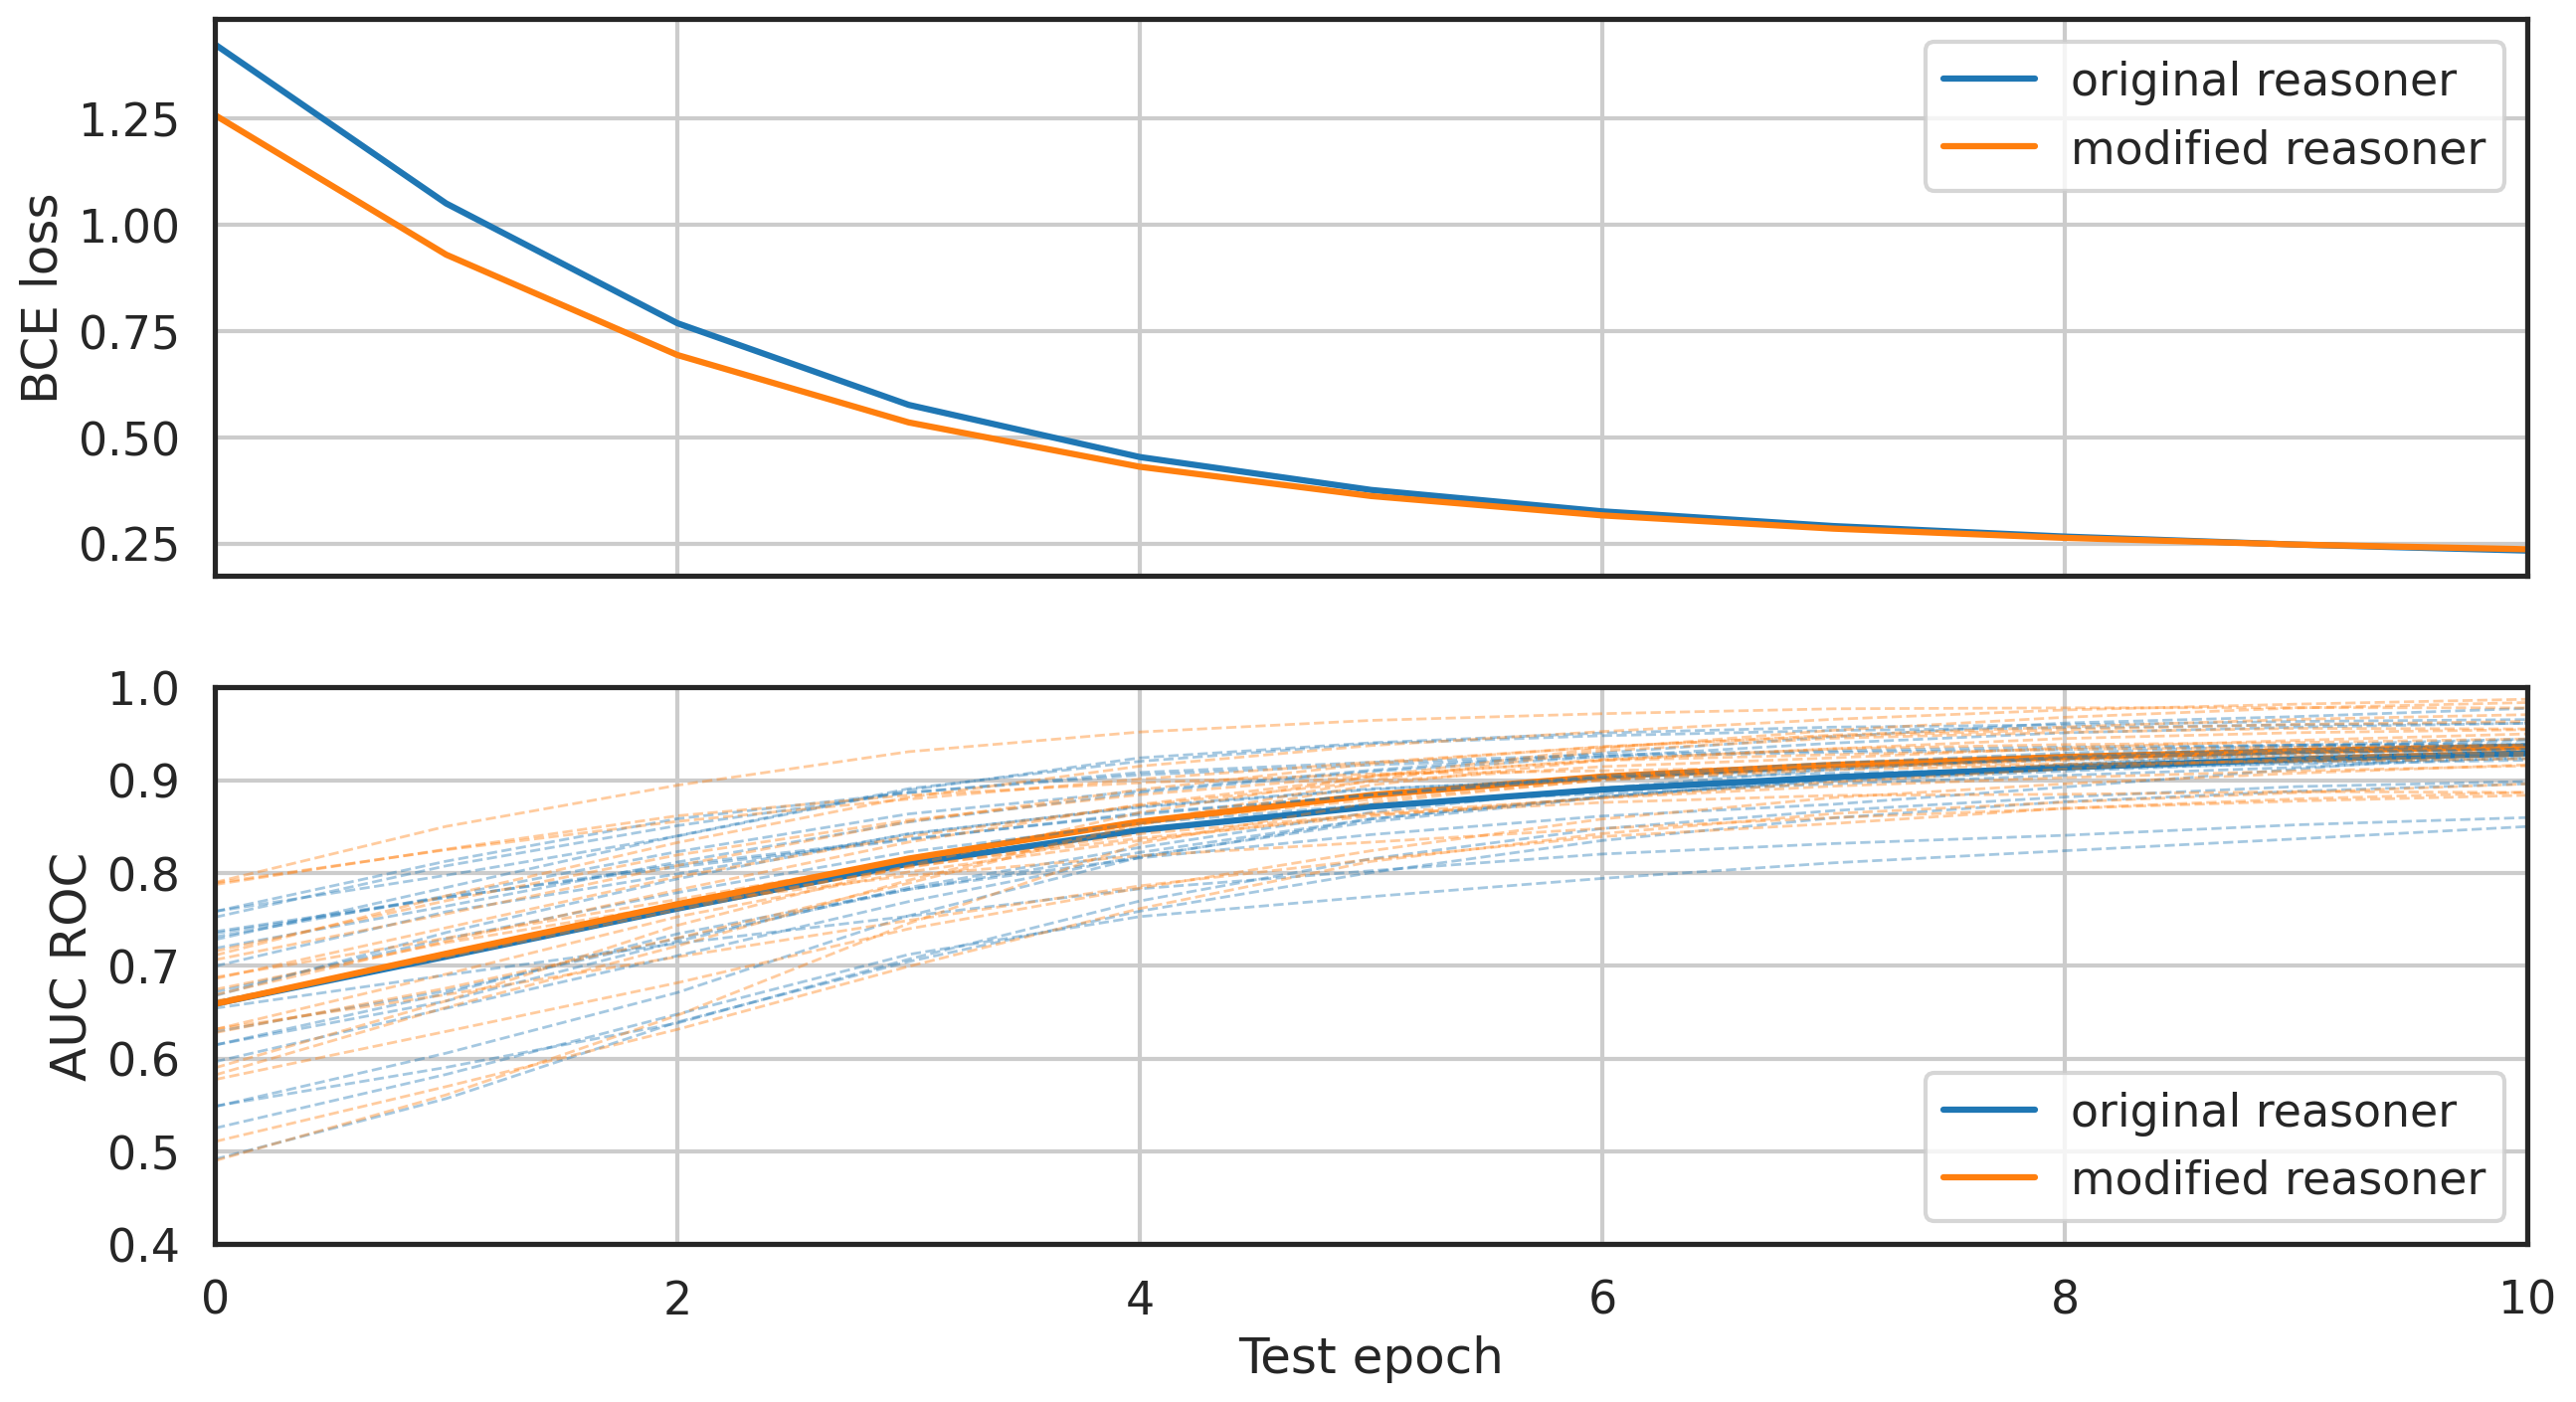

original
             mean       std     micro
acc      0.922319  0.021954  0.922319
prec     0.877242  0.053678  0.875839
recall   0.747164  0.067262  0.748709
f1       0.805830  0.055246  0.807300
auc_roc  0.921333  0.028940  0.922536
auc_pr   0.872541  0.043141  0.874685
modified
             mean       std     micro
acc      0.918204  0.023790  0.918204
prec     0.835738  0.059622  0.836116
recall   0.774614  0.068481  0.775674
f1       0.802852  0.056984  0.804762
auc_roc  0.930066  0.027132  0.931032
auc_pr   0.879232  0.047548  0.882228


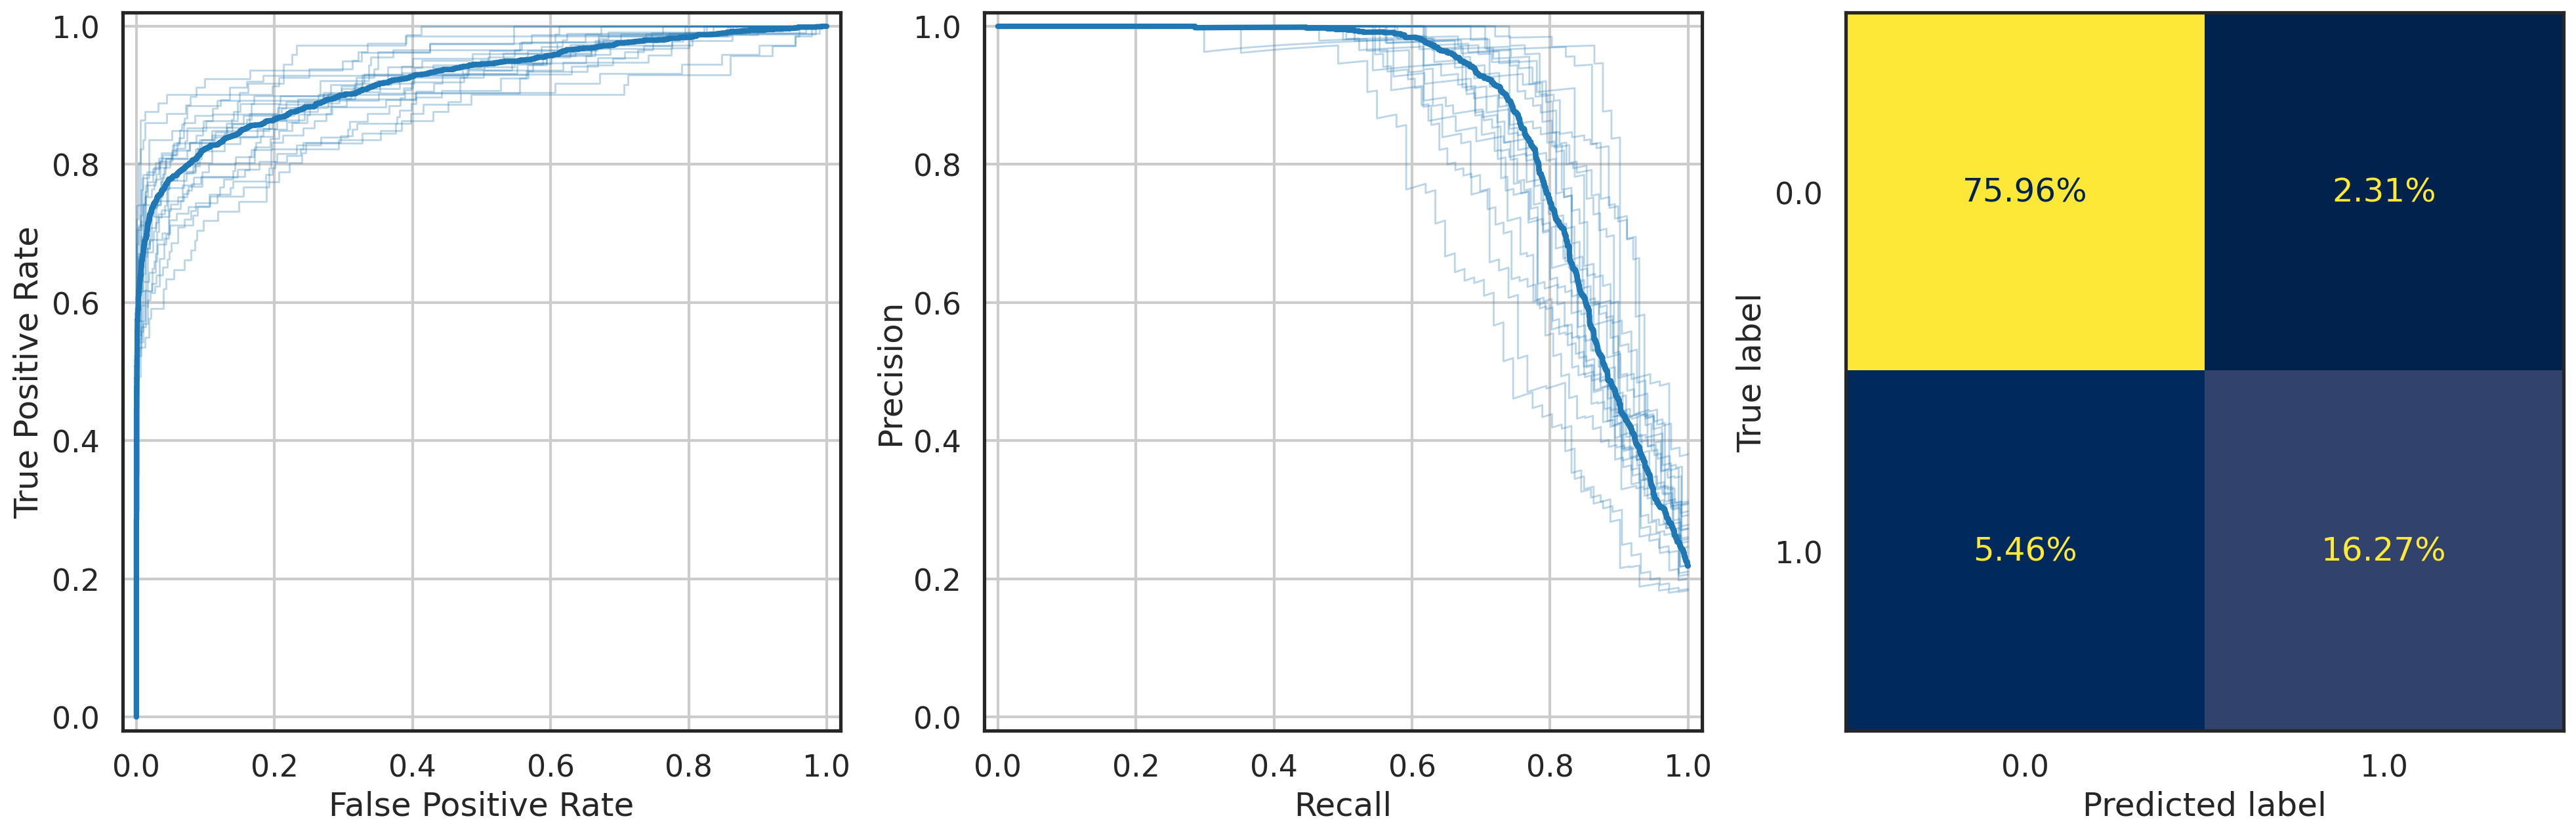

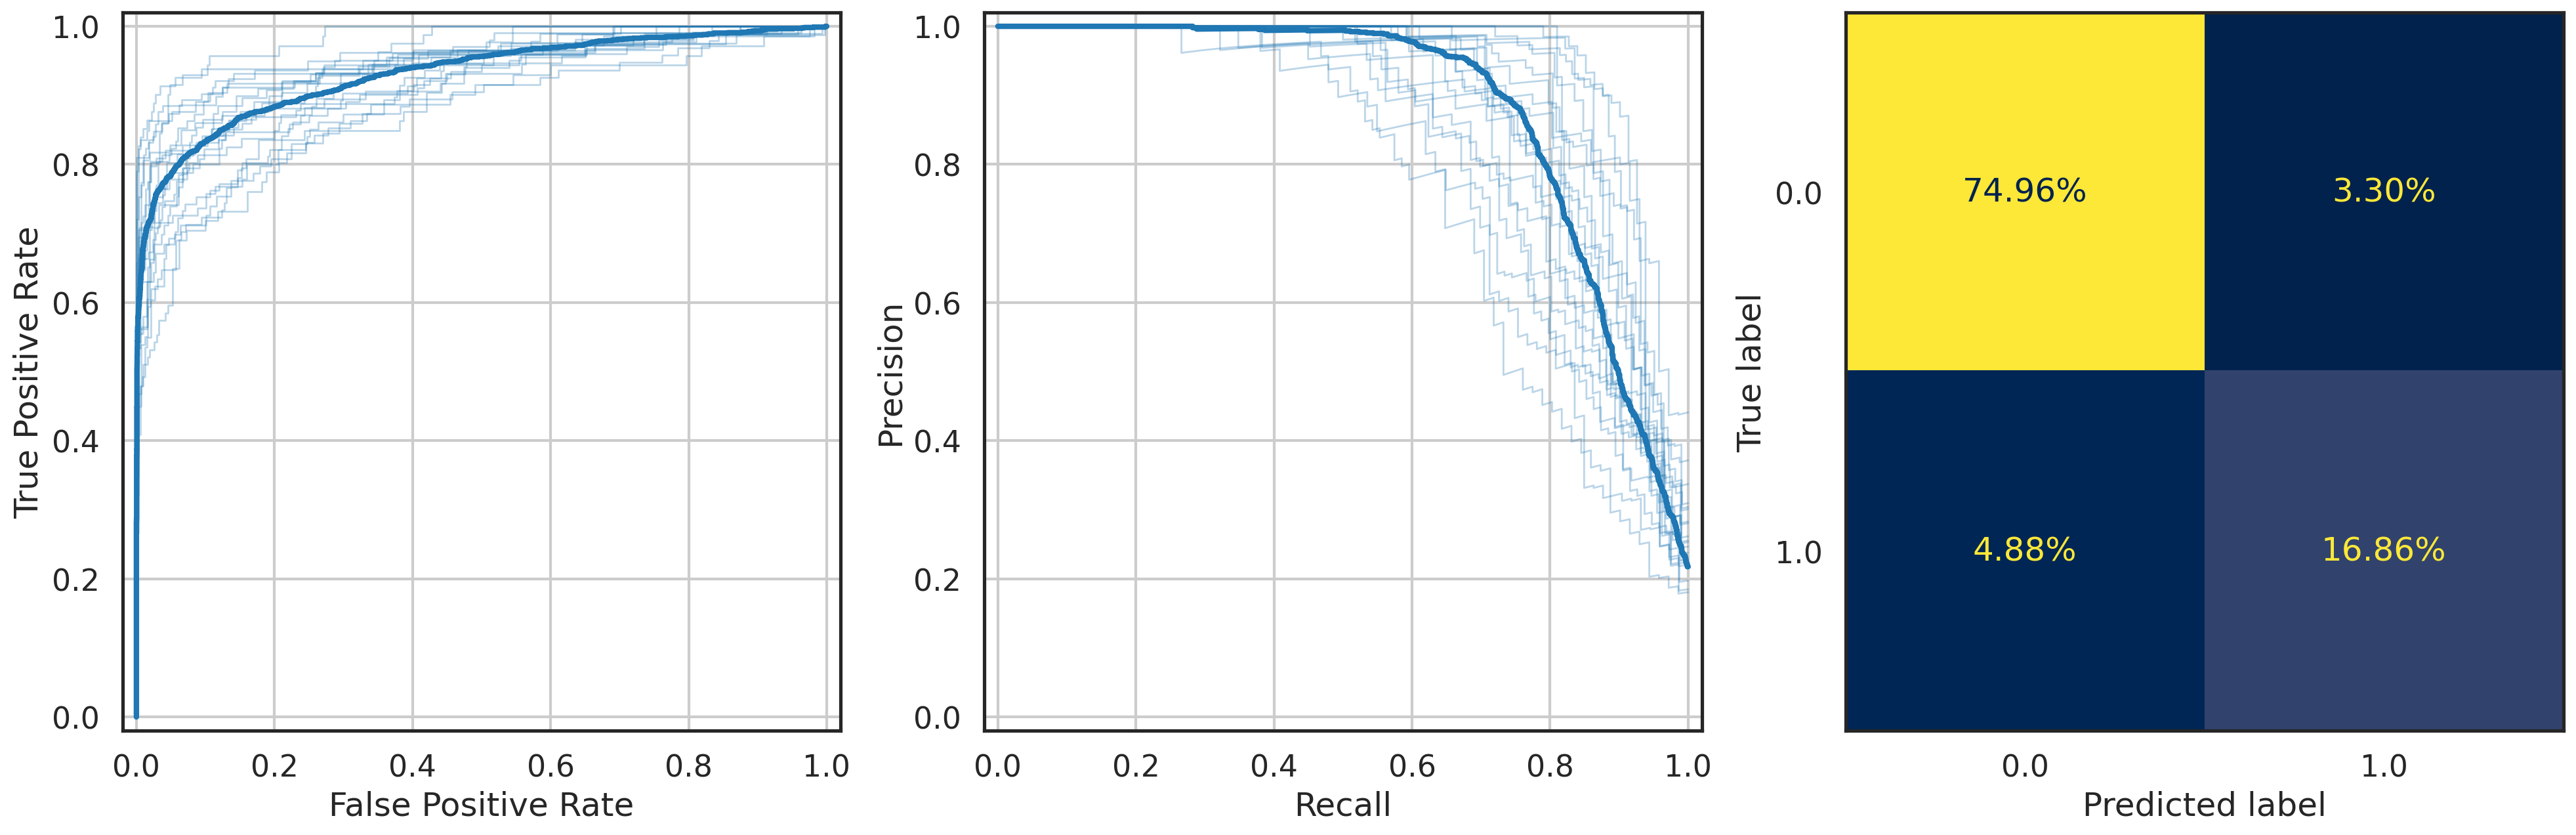

In [7]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

# T.save(reasoner_original.state_dict(), base+'/reasonerO.pt')
# T.save(reasoner_mod.state_dict(), base+'/reasonerM.pt')

# df_tr = pd.DataFrame(train_logger.history_tr)
# df_vl = pd.DataFrame(train_logger.history_vl)
# df_tr.to_csv(base+'/train.csv', index=False)
# df_vl.to_csv(base+'/valid.csv', index=False)
# plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_orig=Y_te_orig, Y_te_mod=Y_te_mod))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print('original')
print(report(test_onto, y_te, np.array(Y_te_orig), idx_te, save=base+'/%-trained'))
print('modified')
print(report(test_onto, y_te, np.array(Y_te_mod), idx_te, save=base+'/%-random'))

In [8]:
from src.id import print_identity_results
print(print_identity_results(reasoner_original,trained_test_encoders['original reasoner'], seed))

Double Negation:
  Mean Loss: 0.269879
  Std Dev Loss: 0.031527
  Mean Diff: 0.545209
  Std Dev Diff: 0.090018

Duality of Top and Bottom:
  Mean Loss: 0.380861
  Std Dev Loss: 0.000000
  Mean Diff: 0.725492
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.127191
  Std Dev Loss: 0.032911
  Mean Diff: 0.316875
  Std Dev Diff: 0.090064

Associativity:
  Mean Loss: 0.032665
  Std Dev Loss: 0.010327
  Mean Diff: 0.075667
  Std Dev Diff: 0.024149

Commutativity:
  Mean Loss: 0.036528
  Std Dev Loss: 0.012431
  Mean Diff: 0.085810
  Std Dev Diff: 0.031189

Contradiction:
  Mean Loss: 0.373475
  Std Dev Loss: 0.019276
  Mean Diff: 0.792812
  Std Dev Diff: 0.060151

Identity with Top:
  Mean Loss: 0.160620
  Std Dev Loss: 0.039015
  Mean Diff: 0.375492
  Std Dev Diff: 0.106224

Absorption by Bottom:
  Mean Loss: 0.369089
  Std Dev Loss: 0.017790
  Mean Diff: 0.751292
  Std Dev Diff: 0.046842

Top Concept Subsumption:
  Mean Loss: 0.000680
  Std Dev Loss: 0.000824
  Mean Diff: N/A
  Std De

In [9]:
print(print_identity_results(reasoner_mod,trained_test_encoders['modified reasoner'], seed))

Double Negation:
  Mean Loss: 0.000020
  Std Dev Loss: 0.000008
  Mean Diff: 0.000055
  Std Dev Diff: 0.000029

Duality of Top and Bottom:
  Mean Loss: 0.000812
  Std Dev Loss: 0.000000
  Mean Diff: 0.001541
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.110708
  Std Dev Loss: 0.028053
  Mean Diff: 0.259923
  Std Dev Diff: 0.073235

Associativity:
  Mean Loss: 0.021050
  Std Dev Loss: 0.007119
  Mean Diff: 0.047285
  Std Dev Diff: 0.015899

Commutativity:
  Mean Loss: 0.024982
  Std Dev Loss: 0.009045
  Mean Diff: 0.058288
  Std Dev Diff: 0.021309

Contradiction:
  Mean Loss: 0.138790
  Std Dev Loss: 0.037808
  Mean Diff: 0.223394
  Std Dev Diff: 0.043800

Identity with Top:
  Mean Loss: 0.067390
  Std Dev Loss: 0.018706
  Mean Diff: 0.159248
  Std Dev Diff: 0.049266

Absorption by Bottom:
  Mean Loss: 0.018621
  Std Dev Loss: 0.008834
  Mean Diff: 0.042724
  Std Dev Diff: 0.017001

Top Concept Subsumption:
  Mean Loss: 0.001001
  Std Dev Loss: 0.001009
  Mean Diff: N/A
  Std De